<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ElasticNet-on-Barclays" data-toc-modified-id="ElasticNet-on-Barclays-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ElasticNet on Barclays</a></span></li></ul></div>

# ElasticNet on Barclays

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import ElasticNet

from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import random as rd
import warnings
import pandas as pd

display(HTML("<style>.container { width:80% !important; }</style>"))
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [4]:
FTSE_volatility_df = pd.read_csv('../data/1.3-FTSE_Monthly_ESG_Volatility_Final.csv')
FTSE_volatility_df = FTSE_volatility_df.rename(columns={'Date_x':'date_key'})
asset = 8589934333

sample_df = FTSE_volatility_df[FTSE_volatility_df.Asset == asset]
sample_df = sample_df[sample_df['V^YZ'].notnull()].reset_index(drop=True)
display(sample_df)

,date_key,month_key,Asset,Open,High,Low,Close,Return,buzz,ESG,ESGCombined,ESGControversies,EnvironmentalPillar,GovernancePillar,SocialPillar,CSRStrategy,Community,Emissions,EnvironmentalInnovation,HumanRights,Management,ProductResponsibility,ResourceUse,Shareholders,Workforce,V^CC,V^RS,V^YZ
0,2006-02-28,2006-02-01,8589934333,6.058889,6.076881,5.986920,6.013908,-0.007424,5772.5,85.0,61.0,38.0,76.0,89.0,91.0,51.0,92.0,60.0,84.0,80.0,94.0,82.0,59.0,96.0,99.0,0.012428,0.013125,0.013810
1,2006-03-31,2006-03-01,8589934333,6.094874,6.126360,6.045395,6.058889,-0.008100,6653.5,82.0,59.0,36.0,69.0,87.0,91.0,45.0,93.0,55.0,82.0,88.0,93.0,74.0,35.0,96.0,99.0,0.010196,0.012146,0.013265
2,2006-04-28,2006-04-01,8589934333,6.135356,6.216321,6.103870,6.162344,0.004399,6734.0,80.0,55.0,30.0,63.0,86.0,91.0,38.0,87.0,25.0,79.0,93.0,93.0,76.0,36.0,97.0,100.0,0.009447,0.010984,0.011757
3,2006-05-31,2006-05-01,8589934333,5.253736,5.573098,5.226747,5.559604,0.048346,6355.5,81.0,57.0,33.0,64.0,89.0,91.0,34.0,87.0,42.0,77.0,94.0,97.0,76.0,36.0,96.0,99.0,0.018942,0.016143,0.017511
4,2006-06-30,2006-06-01,8589934333,5.577596,5.595588,5.483137,5.528118,0.005728,6034.5,82.0,59.0,36.0,67.0,87.0,93.0,29.0,92.0,29.0,83.0,88.0,94.0,84.0,43.0,98.0,100.0,0.019268,0.015390,0.018217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2022-08-31,2022-08-01,8589934333,1.656600,1.669599,1.641400,1.645001,-0.001214,41760.5,49.0,31.0,13.0,75.0,18.0,54.0,85.0,12.0,69.0,82.0,85.0,5.0,3.0,55.0,21.0,89.0,0.016873,0.015432,0.016869
199,2022-09-30,2022-09-01,8589934333,1.440400,1.476187,1.416799,1.443000,-0.002489,42463.0,48.0,31.0,13.0,76.0,18.0,51.0,85.0,7.0,78.0,84.0,82.0,5.0,2.0,42.0,16.0,87.0,0.018706,0.020202,0.021214
200,2022-10-31,2022-10-01,8589934333,1.470800,1.491197,1.466400,1.477600,0.009014,47353.5,58.0,35.0,12.0,74.0,52.0,48.0,85.0,6.0,84.0,88.0,77.0,43.0,2.0,9.0,59.0,81.0,0.021406,0.024083,0.025140
201,2022-11-30,2022-11-01,8589934333,1.617800,1.628000,1.603500,1.612400,0.001491,51001.5,52.0,31.0,11.0,73.0,35.0,47.0,86.0,10.0,85.0,87.0,71.0,17.0,2.0,4.0,62.0,80.0,0.011400,0.015951,0.016662


In [6]:
init_remove = ['date_key', 'month_key', 'Asset', 'Return', 'V^CC', 'V^RS']
sample_df = sample_df.drop(init_remove, axis=1)

---

In [8]:
test_size = int(sample_df.shape[0]*0.2)

In [9]:
df_train, df_test = sample_df.iloc[:-test_size,], sample_df.iloc[-test_size:,]

In [10]:
y_train = df_train['V^YZ']

# Define the independent variables
X_train = df_train.drop(['V^YZ'], axis=1)

# Add a constant to the independent variables matrix

In [13]:
# Train the model
model = ElasticNet(l1_ratio=0.5)  # set l1_ratio to something between 0 and 1. 0.5 gives equal weight to L1 and L2 penalties
model.fit(X_train, y_train)

ElasticNet()

In [14]:
y_test = df_test['V^YZ']

# Define the independent variables
X_test = df_test.drop(['V^YZ'], axis=1)

# Add a constant to the independent variables matrix

In [15]:
y_pred = model.predict(X_test)

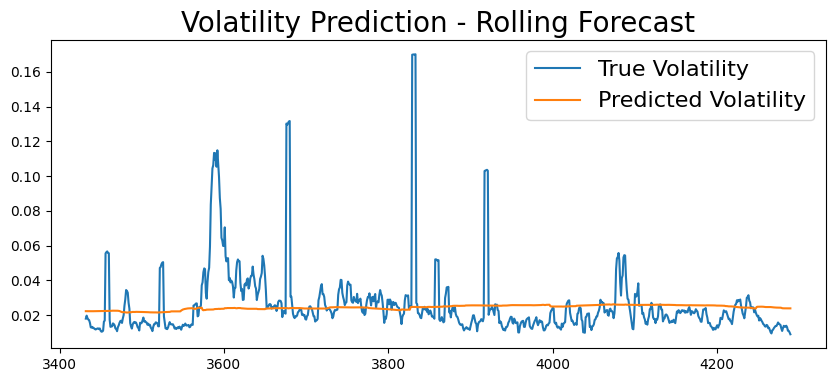

In [16]:
plt.figure(figsize=(10,4))
true, = plt.plot(y_test)
preds, = plt.plot(pd.Series(y_pred, index=y_test.index))
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

In [17]:
mse_million = mean_squared_error(y_test,y_pred)*10**6

In [18]:
GARCH_results = pd.DataFrame({
    'Model':'Heterogeneous AutoRegressive',
    'Test Size': test_size,
    'MSE^6':mse_million
             }
    , index=[0]
)
display(GARCH_results)

,Model,Test Size,MSE^6
0,Heterogeneous AutoRegressive,858,427.780119


---

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv('../data/AirPassengers.csv')

# Preprocessing
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
indexed_df = df.set_index(['Month'])

# Decompose the time series to get the trend
decomposition = seasonal_decompose(indexed_df)

trend = decomposition.trend
trend = trend.dropna()

# Scale the data between 0 and 1
scaler = MinMaxScaler()
trend_scaled = scaler.fit_transform(trend.values.reshape(-1,1))

# Prepare the data for the ElasticNet model
X = [trend_scaled[i] for i in range(len(trend_scaled) - 2)]
y = [trend_scaled[i] for i in range(2, len(trend_scaled))]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape the data to 2D, since ElasticNet expects a 2D input
X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Train the ElasticNet model
enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
enet.fit(X_train, y_train)

# Make predictions
pred = enet.predict(X_test)

# Compute the mean squared error of the predictions
mse = mean_squared_error(y_test, pred)
print(f'Test MSE: {mse}')


Test MSE: 0.04664452524338289
